# Continuous Glucose Monitoring Sentiment Analysis
## Final Notebook, Data Science for Product Managers Project 1
### Sai R., Jonathan W., Nehal C.
#### 10/13/2022

The purpose of The Data Science for Diabetes Management Group (DSDMG) is to analyze and research the status quo around current Diabetes technologies/research in order to fast-track solutions to existing problems. In 2019, diabetes was the direct cause of 1.5 million deaths in 2019. Thus, it is imperative that solutions are effective and quickly implemented. In this notebook we analyze current CGM sentiment, compare Dexcom and FreeStyle Libre, and make recommendations for existing companies to market their strengths and bolster the weaknesses, or for disruptors to enter the market and capitalize on the unmet needs of the consumer.


## Data Setup

In [ ]:
# imports
import re #regular expressions
import spacy #natural language processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from nltk import tokenize # fast sentence tokenization
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import scikitplot as skplt
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

import nltk
import string

nltk.download('words')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.downloader.download('vader_lexicon')

words = set(nltk.corpus.words.words())
nlp = spacy.load('en_core_web_md') # load up nlp
stop = set(nlp.Defaults.stop_words) | set(string.punctuation) # stop words and punctuation set

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package words to /Users/jwang/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/jwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/jwang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/jwang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jwang/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jwang/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Import and Cleaning

The first step prior to analyzing the data was to import and clean the Diabetes Continuous Glucose Monitoring – Data Export. The main steps were to select 'Post ID', 'Sound Bite Text', 'Title', 'Source Type', 'Source Name', 'Sentiment', 'Positive Objects', and 'Negative Objects' as the main data columns, and create an 'entire_text' column combining the 'Sound Bite Text', 'Title', 'Positive Objects', and 'Negative Objects'. This 'entire_text' column would then be used for the creation of the train/test set.

The target variable we chose was the sentiment. The sentiment targets were '0' for 'mixed, '1' for 'negative', '2' for 'neutral', and '3' for 'positive'.

In [ ]:
df = pd.read_excel("Diabetes Continuous Glucose Monitoring – Data Export.xlsx")
# Keep relevant columns
df = df[['Post ID', 'Sound Bite Text', 'Title', 'Source Type', 'Source Name', 'Sentiment', 'Positive Objects', 'Negative Objects']]
df = df.drop_duplicates(subset=['Sound Bite Text'])

#Remove na
df['Title'] = df[['Title']].fillna('')
df['Positive Objects'] = df[['Positive Objects']].fillna('')
df['Negative Objects'] = df[['Negative Objects']].fillna('')
# Create a combined column of all post text
df['entire_text'] = df['Sound Bite Text'] + ' ' + df['Title'] + ' ' + df['Positive Objects'] + ' ' + df['Negative Objects'] 

df['Sentiment'].unique()
df['Sentiment'] = pd.Categorical(df['Sentiment'])

df['target'] = df['Sentiment'].cat.codes

target_mapping = df.groupby(['Sentiment','target']).size().reset_index()
target_mapping = target_mapping[target_mapping[0] != 0]

In [ ]:
target_mapping[['Sentiment','target']]

,Sentiment,target
0,Mixed,0
5,Negatives,1
10,Neutrals,2
15,Positives,3


In [ ]:
df.head()

,Post ID,Sound Bite Text,Title,Source Type,Source Name,Sentiment,Positive Objects,Negative Objects,entire_text,target
0,BRDRDT2-t1_imq98sr,My numbers are great now. Estimated a1c of 7%i...,Have you been denied a second/third pump? Feel...,Forums,r/diabetes_t1,Neutrals,number,,My numbers are great now. Estimated a1c of 7%i...,2
1,BRDRDT2-t1_impbcf4,I tried it for a little while. No side effects...,Metformin,Forums,r/diabetes_t1,Positives,,,I tried it for a little while. No side effects...,3
2,1565738759353602048,i ran out of characters. youtu.be/RWgl2PDhQiM ...,,Twitter,NaN,Positives,"dexcom g6, omnipod system",,i ran out of characters. youtu.be/RWgl2PDhQiM ...,3
3,17944607459251789,MY lunch! Ate at 10:30am \n1 unit NovoLog insu...,,Instagram,NaN,Neutrals,,,MY lunch! Ate at 10:30am \n1 unit NovoLog insu...,2
4,BRDRDT2-t1_imq8h9m,This is also because like a soak in a hot tub ...,"No bath salts, bath oils, soaks?",Forums,r/diabetes,Neutrals,,,This is also because like a soak in a hot tub ...,2


## Preprocessing Steps

For this portion we cleaned and lemmatized the data. The outputs are then passed into a function which converts the lemmatized list into a training set. The tf-idf parameters are added, and a trigram approach is used.

In [ ]:
# clean and lemmatize function takes the dataframe, and allows dexcom and libre filtering
def clean_and_lemmatize(df, column, dexcom=False, libre=False):
    text = df[[column]].to_numpy()
    
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    lemmatizer = WordNetLemmatizer()
    
    cleaned = []
    lemmatized = []
        
    for sentence in text:
        # final word lists will put tokens into strings
        cleaned_lst = []
        lemmatized_lst = []
                
        for word in tokenizer.tokenize(sentence[0].lower()):    
            # get rid of punctuation
            word_filtered = word.translate(str.maketrans('','',string.punctuation))

            # Filtering criterion
            filtering = ((word_filtered not in stop) # word not in stopwords
                        and (len(word_filtered) > 2)    
                        and word_filtered.isalpha()#
                        and not ("https" in word_filtered))
            
            # dexcom and libre triggers
            if dexcom: filtering = filtering and not("dexcom" in word)
            if libre: filtering = filtering and not("libre" in word)
                        
            # add to cleaned and lemmatized lists       
            if filtering:
                cleaned_lst.append(word_filtered)
                lemmatized_lst.append(lemmatizer.lemmatize(word_filtered))
                
            # create final parsed strings
        cleaned.append(' '.join(cleaned_lst))
        lemmatized.append(' '.join(lemmatized_lst))
        
    return {'cleaned': cleaned, 'lemmatized': lemmatized}

In [ ]:
my_stop_words = text.ENGLISH_STOP_WORDS.union(["continuous", "glucose", "monitor", "dexcom", "freestyle", "libre", "cgm", "blood", "sugar", "pump", "diabetes", "insulin"])
# source https://stackoverflow.com/questions/26826002/adding-words-to-stop-words-list-in-tfidfvectorizer-in-sklearn

def create_training_set(df,column, min_df, max_df, dexcom=False, libre=False):
    entire_text_dic = clean_and_lemmatize(df, column, dexcom, libre)
    entire_text_merged = " ".join(["".join([str(item) for item in sublist]) for sublist in entire_text_dic['cleaned']])
    
    entire_text_tokenized = nltk.tokenize.word_tokenize(entire_text_merged)
    
    # tfidf_vectorizer= TfidfVectorizer(min_df=600, stop_words="english", max_df=0.8, 
    tfidf_vectorizer= TfidfVectorizer(min_df=min_df, stop_words=my_stop_words, max_df=max_df, 
                                    analyzer="word", token_pattern=r"(?u)\b[A-Za-z']+\b", ngram_range=(3,3))
    
    df['lemmatized_entire_text'] = entire_text_dic['lemmatized']

    tf_idf_entire_text = tfidf_vectorizer.fit_transform(entire_text_dic['lemmatized']).toarray()
    
    features = tf_idf_entire_text
    labels = df['target']
    
    return {'cleaned': entire_text_dic['cleaned'], 'lemmatized': entire_text_dic['lemmatized'], 'features': features, 'labels': labels, 'entire_text_tokens': entire_text_tokenized, 'feature_names':tfidf_vectorizer.get_feature_names()}

In [ ]:
entire_text_set = create_training_set(df, 'entire_text', 20, 0.95)

In [ ]:
entire_text_set['feature_names']

['aaps broadcast feature',
 'advice needed tslim',
 'aita checking desk',
 'alarm time leave',
 'alert high low',
 'app update base',
 'apple watch likely',
 'apple watch series',
 'apple watch work',
 'appreciate hospital low',
 'base version update',
 'better hear sensor',
 'biggest game changer',
 'blue cross blue',
 'broadcast feature program',
 'build app update',
 'check finger stick',
 'check time day',
 'checking desk coworker',
 'checking time day',
 'close loop tslim',
 'closed loop omnipod',
 'closest thing cure',
 'come long way',
 'considering ditching medtronic',
 'constant sensor end',
 'continuing tired abusing',
 'couple day ago',
 'couple month ago',
 'couple week ago',
 'couple year ago',
 'coworker severe phobia',
 'cross blue shield',
 'curiosity thread pay',
 'daily meme day',
 'day finger prick',
 'day new sensor',
 'desk coworker severe',
 'device attached body',
 'diabetebuddies warranty thinking',
 'diabetic alert dog',
 'diabetic hate idea',
 'diabetic possib

### POS Tagging
The function below calculates and returns lists of adjectives, nouns, and proper nouns, as well as their respective frequencies.

In [ ]:
# part of speech tagging function
# takes in a cleaned data column
def getPOS(data_cleaned):
    adjs = []
    nouns = []
    propns = []
    adj_counter = Counter()
    noun_counter = Counter()
    propns_counter = Counter()  
    for post in data_cleaned:
        for word in nlp(post.lower()):
            word_pos = word.pos_
            # remove stop words
            if word.text in nlp.Defaults.stop_words or word.text == "-":
                continue
            elif word_pos == 'ADJ':
                adjs.append(word.text)
            elif word_pos == 'NOUN':
                nouns.append(word.text)
            elif word_pos == 'PROPN':
                propns.append(word.text)

    # update counters for part of speech
    adj_counter.update(adjs)
    noun_counter.update(nouns)
    propns_counter.update(propns)
    return [adj_counter, noun_counter, propns_counter, [adjs, nouns, propns]]

# EDA
In this section we conduct exploratory plots of word frequencies, source type proportions, and compare Dexcom and Libre features.

In [ ]:
adj_counter, noun_counter, propns_counter, others = getPOS(entire_text_set['cleaned'])


## Wordclouds

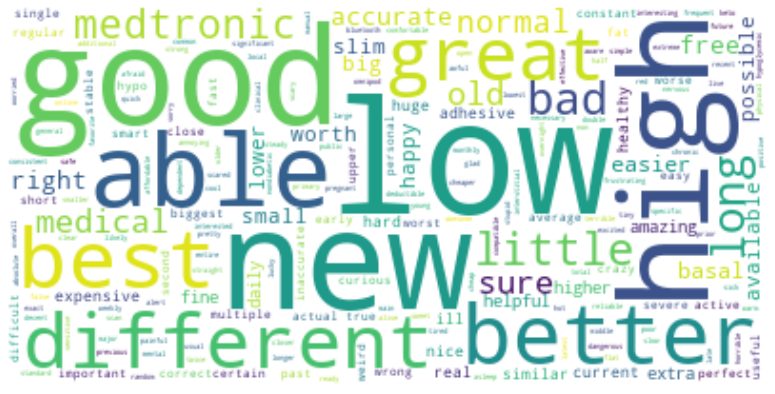

In [ ]:
adj_text = " ".join(i for i in others[0])
# Remove some common words that give no value to the plot
stopwords = {"diabetic", "continuous"}
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(adj_text)
plt.figure( figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

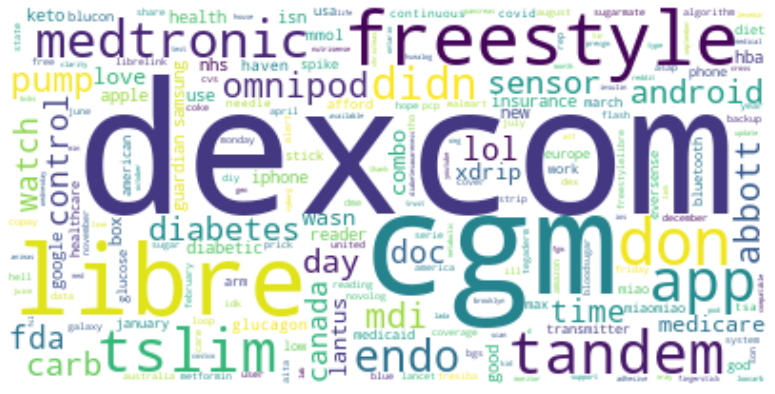

In [ ]:
propn_text = " ".join(i for i in others[2])
# While Dexcom and Libre are obviously in the dataset and not informative,
# the relative size is informational.
stopwords = {}
wordcloud = WordCloud(stopwords=stopwords, background_color="white", collocations=False).generate(propn_text)
plt.figure( figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

For now, we grab Dexcom and Libre from the specific subreddits because it's easy. Next, we will categorize the posts more succinctly.

In [ ]:
df_dexcom_short = df[df["Source Name"]=='r/dexcom']
df_libre_short = df[df["Source Name"]=='r/Freestylelibre']

## Categorizing posts
Here we categorize posts by whether or not they mention Dexcom/G6, FreeStyle Libre/Libre, both, or neither.

In [ ]:
def getCategory(post):
    if 'dexcom' in post or 'g6' in post:
        if 'libre' in post or 'freestyle' in post:
            return 'both'
        else:
            return 'dexcom'
    elif 'libre' in post or 'freestyle' in post:
        return 'libre'
    else:
        return 'none'

In [ ]:
df['entire_text'] = entire_text_set['cleaned']
df['lemmatized_entire_text'] = entire_text_set['lemmatized']

In [ ]:
dexcom = []
libre = []
both = []
neither = []
for ind, row in df.iterrows():
    subject = getCategory(row['entire_text'].lower())
    if subject == 'dexcom':
        dexcom.append(ind)
    elif subject == 'libre':
        libre.append(ind)
    elif subject == 'both':
        both.append(ind)
    else:
        neither.append(ind)
    

In [ ]:
# Checking for Balanced Classes
print("Dexcom: " , len(dexcom))
print("Libre: " , len(libre))
print("Both: " , len(both))
print("Neither: " , len(neither))

Dexcom:  17227
Libre:  4332
Both:  3086
Neither:  13199



EDA of Dexcom vs Libra data after categorization.

In [ ]:
df_dexcom = df.iloc[dexcom]
df_libre = df.iloc[libre]
df_both = df.iloc[both]
df_neither = df.iloc[neither]

dexcom_set = create_training_set(df_dexcom, 'entire_text', 11, 0.8, dexcom=True)

libre_set = create_training_set(df_libre, 'entire_text', 6, 0.8, libre=True)


df_dexcom['entire_text'] = dexcom_set['cleaned']
df_dexcom['lemmatized_entire_text'] = dexcom_set['lemmatized']

df_libre['entire_text'] = libre_set['cleaned']
df_libre['lemmatized_entire_text'] = libre_set['lemmatized']

adj_dexcom, noun_dexcom, propns_dexcom, others_dex = getPOS(df_dexcom['entire_text'])
adj_libre, noun_libre, propns_libre, others_lib = getPOS(df_libre['entire_text'])

In [ ]:
dexcom_set['feature_names'].head()

['aaps broadcast feature',
 'advice needed tslim',
 'advice switching medtronic',
 'alarm time leave',
 'alert high low',
 'amazing guess want',
 'app having lot',
 'app update base',
 'apple watch apple',
 'apple watch series',
 'apple watch work',
 'base version update',
 'battling medtronic finally',
 'better hear sensor',
 'blue cross blue',
 'box morning cried',
 'broadcast feature program',
 'build app update',
 'calibrate believe liar',
 'check time day',
 'close loop tslim',
 'closed loop control',
 'closed loop omnipod',
 'closed loop tandem',
 'closed loop tslim',
 'closest thing cure',
 'complication apple watch',
 'considering ditching medtronic',
 'constant sensor end',
 'continuing tired abusing',
 'couple day ago',
 'couple month ago',
 'couple week ago',
 'couple year ago',
 'covered pharmacy benefit',
 'cried diabetic year',
 'cross blue shield',
 'curiosity thread pay',
 'daily meme day',
 'day new sensor',
 'device attached body',
 'diabetebuddies warranty thinking',

In [ ]:
libre_set['feature_names'].head()

['aita checking desk',
 'alarm turned sensor',
 'alert high low',
 'alert low high',
 'app sensor weight',
 'apple watch likely',
 'apple watch series',
 'arm pull dispose',
 'backwards technologically year',
 'belt come mind',
 'belt enters mind',
 'body reacts food',
 'brace neoprene sleeve',
 'certain hulk hogan',
 'check level time',
 'checking desk coworker',
 'cmp patella control',
 'come mind advantage',
 'couple week ago',
 'coworker severe phobia',
 'daily chat post',
 'desk coworker severe',
 'diabetesdiet diabeticfriendly diabetesticmuscleandfitness',
 'diabetesticmuscleandfitness friend family',
 'diabetic absolutely pathetic',
 'diabetic dog got',
 'diabetic iamdiabetic diabeticfood',
 'diabeticfood diabeticlife novamix',
 'diabeticfriendly diabetesticmuscleandfitness friend',
 'diabeticlife novamix novarapid',
 'diabeticmeals diabeticrecipes diabetesdiet',
 'diabeticrecipes diabetesdiet diabeticfriendly',
 'diagnosed month ago',
 'diagnosed year ago',
 'difference reading

## Sentiment Plots
We plot the frequency of sentiments based on post category and then on source type.

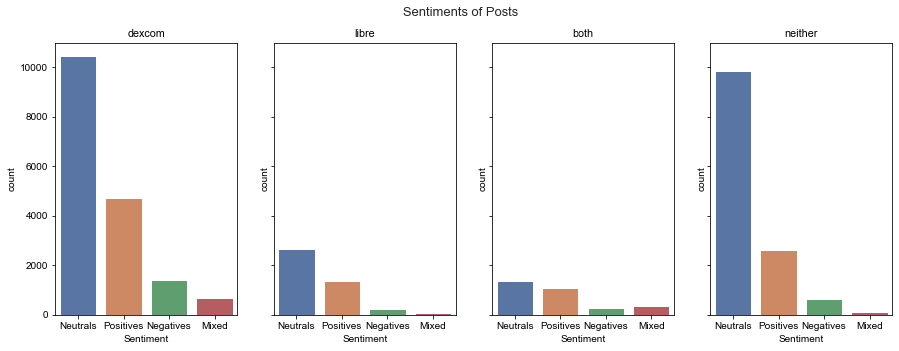

In [ ]:
fig, axes = plt.subplots(1,4, figsize=(15,5),sharey=True)
sns.set_theme(style="whitegrid", font_scale=0.9)
fig.suptitle("Sentiments of Posts")
# Dexcom
sns.countplot(ax=axes[0], data=df_dexcom, x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])
#Libre
sns.countplot(ax=axes[1], data=df_libre, x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])
#Both
sns.countplot(ax=axes[2], data=df_both, x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])
#Neither
sns.countplot(ax=axes[3], data=df_neither, x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])

axes[0].set_title('dexcom')
axes[1].set_title('libre')
axes[2].set_title('both')
axes[3].set_title('neither')
plt.show(sns)

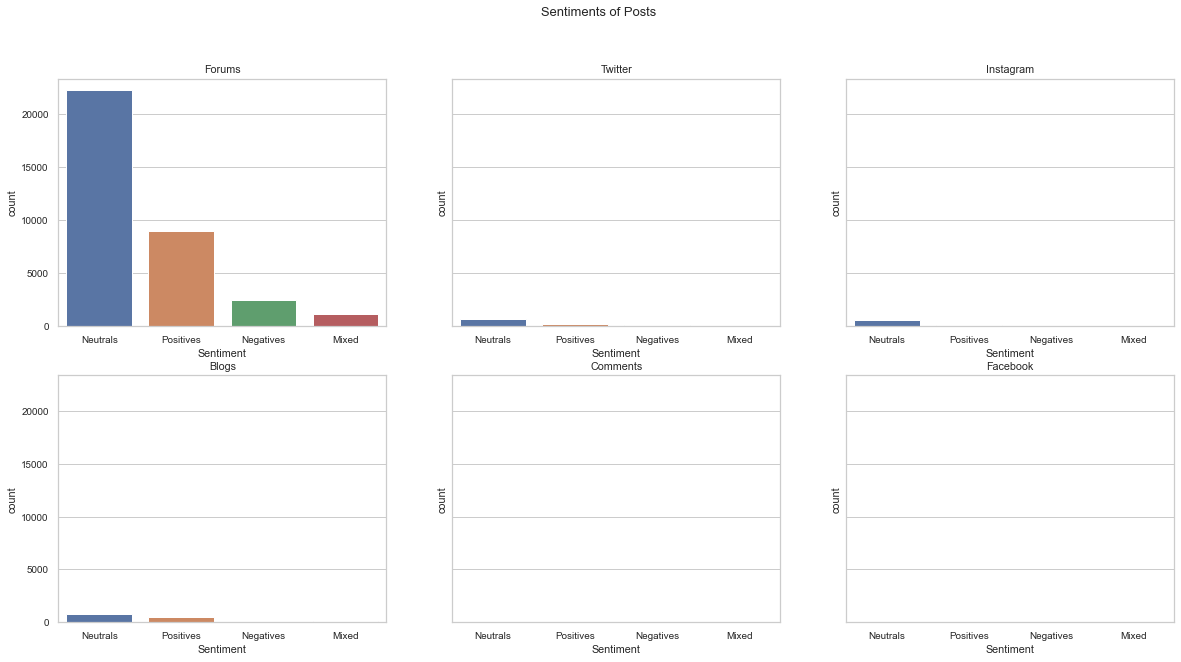

In [ ]:
fig, axes = plt.subplots(2,3, figsize=(20,10),sharey=True)
sns.set_theme(style="whitegrid", font_scale=0.9)
fig.suptitle("Sentiments of Posts")
#Forums
sns.countplot(ax=axes[0, 0], data=df[df['Source Type']=='Forums'], x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])
#Twitter
sns.countplot(ax=axes[0, 1], data=df[df['Source Type']=='Twitter'], x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])
#Instagram
sns.countplot(ax=axes[0, 2], data=df[df['Source Type']=='Instagram'], x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])
#Blogs
sns.countplot(ax=axes[1, 0], data=df[df['Source Type']=='Blogs'], x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])
#Comments
sns.countplot(ax=axes[1, 1], data=df[df['Source Type']=='Comments'], x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])
#Facebook
sns.countplot(ax=axes[1, 2], data=df[df['Source Type']=='Facebook'], x='Sentiment', order = ['Neutrals', 'Positives', 'Negatives', 'Mixed'])

axes[0, 0].set_title('Forums')
axes[0, 1].set_title('Twitter')
axes[0, 2].set_title('Instagram')
axes[1, 0].set_title('Blogs')
axes[1, 1].set_title('Comments')
axes[1, 2].set_title('Facebook')

plt.show(sns)

## Proportion of Source Types
This is a better version of the plot above.

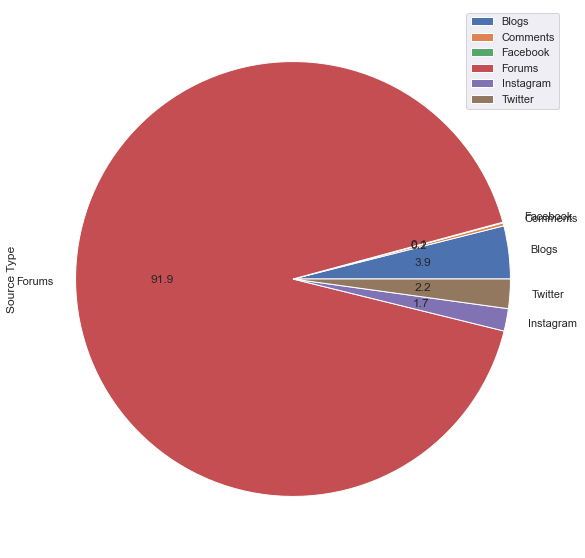

In [ ]:
pie_df = pd.DataFrame((df.groupby('Source Type')['Source Type'].count()/len(df)))

plot = pie_df.plot.pie(subplots=True, figsize=(10, 10), autopct='%1.1f')

## Adjective and Proper Noun frequencies
Here we plot the frequencies of the top 3 adjectives and the top 30 proper nouns in Dexcom and Libre categorized posts.

In [ ]:
# Create an adjective dataframe for dexcom and libre, for plotting
adjs_df_dexcom = pd.DataFrame.from_dict(adj_dexcom, orient="index").reset_index()
adjs_df_dexcom.columns = ['adj', 'freq']
adjs_df_dexcom = adjs_df_dexcom.sort_values(by='freq', ascending=False)
adjs_df_dexcom_30 = adjs_df_dexcom.nlargest(30, 'freq')

adjs_df_libre = pd.DataFrame.from_dict(adj_libre, orient="index").reset_index()
adjs_df_libre.columns = ['adj', 'freq']
adjs_df_libre = adjs_df_libre.sort_values(by='freq', ascending=False)
adjs_df_libre_30 = adjs_df_libre.nlargest(30, 'freq')

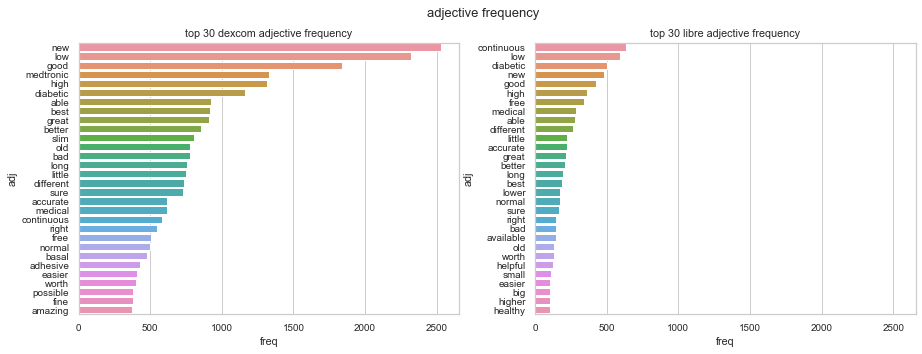

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,5), sharex=True)
sns.set_theme(style="whitegrid", font_scale=0.9)
fig.suptitle("adjective frequency")
sns.barplot(ax=axes[0], x='freq', y='adj', data=adjs_df_dexcom_30).set(title="top 30 dexcom adjective frequency")
sns.barplot(ax=axes[1], x='freq', y='adj', data=adjs_df_libre_30).set(title="top 30 libre adjective frequency")
plt.show()

In [ ]:
# Create a proper nouns dataframe for dexcom and libre, for plotting
propns_df_dexcom = pd.DataFrame.from_dict(propns_dexcom, orient="index").reset_index()
propns_df_dexcom.columns = ['adj', 'freq']
propns_df_dexcom = propns_df_dexcom.sort_values(by='freq', ascending=False)
propns_df_dexcom_30 = propns_df_dexcom.nlargest(30, 'freq')

propns_df_libre = pd.DataFrame.from_dict(propns_libre, orient="index").reset_index()
propns_df_libre.columns = ['adj', 'freq']
propns_df_libre = propns_df_libre.sort_values(by='freq', ascending=False)
propns_df_libre_30 = propns_df_libre.nlargest(30, 'freq')

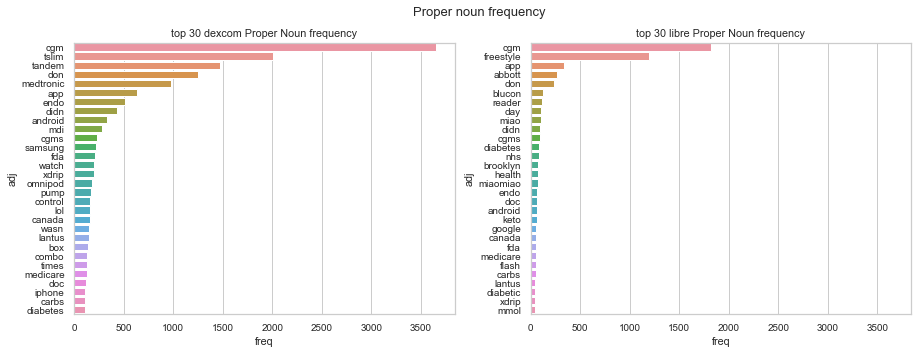

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,5),sharex=True)
sns.set_theme(style="whitegrid", font_scale=0.9)
fig.suptitle("Proper noun frequency")
sns.barplot(ax=axes[0], x='freq', y='adj', data=propns_df_dexcom_30).set(title="top 30 dexcom Proper Noun frequency")
sns.barplot(ax=axes[1], x='freq', y='adj', data=propns_df_libre_30).set(title="top 30 libre Proper Noun frequency")
plt.show()

In [ ]:
entire_text_features = entire_text_set['features']
entire_text_labels = entire_text_set['labels']

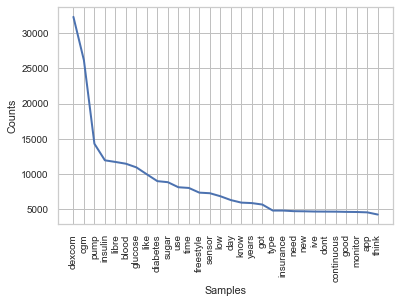

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [ ]:
fdist = FreqDist(entire_text_set['entire_text_tokens'])
fdist.plot(30, cumulative=False)

## Vader Analysis
In this section, we user NLTKs built-in, pretrained sentiment analyzer called VADER (Valence Aware Dictionary and sEntiment Reasoner)

In [ ]:
#A function to get CGM category (Dexcom, Libre, Both or Either) using the texts in the tweet. 
dexcom = []
libre = []
for ind, row in df.iterrows():
    subject = getCategory(row['lemmatized_entire_text'].lower())
    if subject == 'dexcom':
        dexcom.append(ind)
    elif subject == 'libre':
        libre.append(ind)

In [ ]:
#Create numpy array for lemmatized_entire_text
vader_rows = df['lemmatized_entire_text'].to_numpy()

#Use NLTKs Setniment Intensity Analyser - help you determine the ratio of positive to negative engagements about a specific topic.
sia = SentimentIntensityAnalyzer() 

#Get sentiments for each tweet, and return if they fall in Dexcom or Libre Categories. We ignore mixed and either sentiments here. 
def getSentimentScore(tweet): 
    vals = []
    sentences = tokenize.sent_tokenize(tweet)
    for s in sentences:
        subject = getCategory(s.lower())
        if subject == 'dexcom' or subject == 'libre':
            return sia.polarity_scores(s)['compound']
    return None

In [ ]:
#Get Sentiment scores for Dexcom and Libre for the numpy created using lemmatized_entire_text
scores_dexcom = [getSentimentScore(vader_rows[i]) if (i in dexcom) else None for i in range(len(vader_rows))]
scores_libre = [getSentimentScore(vader_rows[i]) if (i in libre) else None for i in range(len(vader_rows))]

#Filter out Neutrals (0) and None data 
scores_dexcom = list(filter(lambda item: item is not None, scores_dexcom))
scores_libre = list(filter(lambda item: item is not None, scores_libre))
scores_dexcom = list(filter(lambda item: item != 0, scores_dexcom))
scores_libre = list(filter(lambda item: item != 0, scores_libre))

In [ ]:
#Find average sentiment for Dexcom and Libre
avg_dex = sum(scores_dexcom)/len(scores_dexcom)
avg_lib = sum(scores_libre)/len(scores_libre)
print(avg_dex)
print(avg_lib)

0.246968110187367
0.3689403558052419


In [ ]:
#Get summary statistics for Dexcom Sentiment Score.
pd.Series(scores_dexcom).describe()

count    16118.000000
mean         0.246968
std          0.585020
min         -0.997000
25%         -0.273200
50%          0.401900
75%          0.765000
max          0.999300
dtype: float64

In [ ]:
#Get summary statistics for Libre Sentiment Score.
pd.Series(scores_libre).describe()

count    4272.000000
mean        0.368940
std         0.535821
min        -0.992000
25%         0.051600
50%         0.542300
75%         0.812600
max         0.999400
dtype: float64

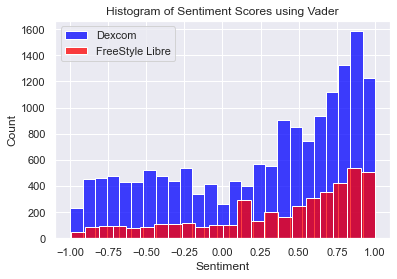

In [ ]:
#Plot the Dexcom and Libre sentiment array on a histogram. 
sns.set(style="darkgrid")
sns.histplot(data=scores_dexcom,label = "Dexcom", color = 'blue')
sns.histplot(data=scores_libre, color = 'red',label = "FreeStyle Libre")
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Histogram of Sentiment Scores using Vader')
plt.legend()
plt.show()

In [ ]:
#Split Positive and Negative Sentiment and create a seprate dataset. 
adjs_pos = []
adjs_neg = []

df_pos = df[df["Sentiment"]=="Positives"]
df_neg = df[df["Sentiment"]=="Negatives"]

In [ ]:
#Create a numpy array from the dataframes created above.
vader_rows_pos = df_pos['lemmatized_entire_text'].to_numpy()
vader_rows_neg = df_neg['lemmatized_entire_text'].to_numpy()

In [ ]:
#Using POS tagging, tag positive adjectives. 
for sent in vader_rows_pos:
    for token in nlp(sent.lower()):
        if token.text in nlp.Defaults.stop_words or len(token) < 3: # remove stop words
            continue 
        #POS tagging
        if token.pos_ == 'ADJ':
            adjs_pos.append(token.text)

In [ ]:
#Using POS tagging, tag negative adjectives. 
for sent in vader_rows_neg:
    for token in nlp(sent.lower()):
        if token.text in nlp.Defaults.stop_words or len(token) < 3: # remove stop words
            continue 
        #POS tagging
        if token.pos_ == 'ADJ':
            adjs_neg.append(token.text)

In [ ]:
#Create counter objects for positive and negative adjectives. 
neg = Counter(adjs_neg)
pos = Counter(adjs_pos)

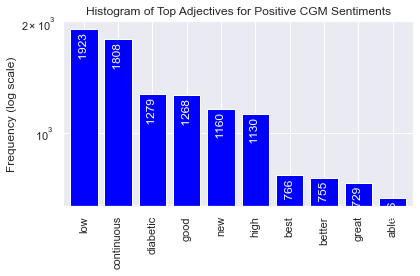

In [ ]:
#Plot 10 most commonly used positive sentiments for CGM products
y = [count for tag, count in pos.most_common(10)]
x = [tag for tag, count in pos.most_common(10)]

plt.bar(x, y, color='blue')
plt.title("Histogram of Top Adjectives for Positive CGM Sentiments")
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(pos.most_common(10)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

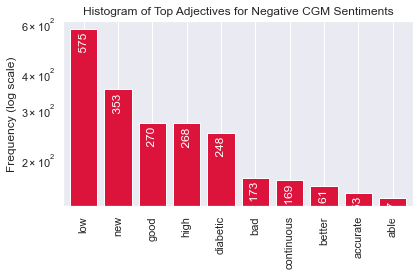

In [ ]:
#Plot 10 most commonly used negative sentiments for CGM products
y = [count for tag, count in neg.most_common(10)]
x = [tag for tag, count in neg.most_common(10)]

plt.bar(x, y, color='crimson')
plt.title("Histogram of Top Adjectives for Negative CGM Sentiments")
plt.ylabel("Frequency (log scale)")
plt.yscale('log') # optionally set a log scale for the y-axis
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(neg.most_common(10)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

## Modeling

We utilized different 3 stages for modeling: an overall sentiment analysis of opinions from the entire dataframe, a Dexcom specified product sentiment analysis, and a Libre specified product sentiment analysis. 

For each one of these stages, we utilized 3 machine learning classification models from the Scikit-learn package distribution: Multinomial Naive Bayes, Random Forest, and XGBoost. This resulted in a total of 9 models. 

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Function to create train/test split, run hyperparameter optimization, and return results
def run_classification_model(model, parameters, features, labels, hyperparam=False):
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=1)
    
    # Hyperparameter optimization toggle using GridSearchCV
    best_model = model
    if(hyperparam):
        cv = HalvingGridSearchCV(model, parameters)
        cv.fit(X_train,y_train)

        print('BEST PARAMS: {}\n'.format(cv.best_params_))

        # store results for best model
        means = cv.cv_results_['mean_test_score'] 
        stds = cv.cv_results_['std_test_score']

        # output results
        for mean, std, params in zip(means, stds, cv.cv_results_['params']):
            print('{} (+/-{}) for {}'.format(round(mean, 3), round(std * 2, 3), params))
            
        best_model = cv.best_estimator_ #choose best model on grid
    else: 
        best_model = model

    best_model.fit(X_train, y_train)

    y_pred_best = best_model.predict(X_test)

    # Output results
    print('Accuracy:', accuracy_score(y_pred_best, y_test))
    print('F1 Score:', f1_score(y_pred_best, y_test, average='weighted'))
    print(classification_report(y_pred_best, y_test))

    return {'best_model': best_model, 'X_train' : X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

In [ ]:
# entire_text_set = create_training_set(df, 'entire_text', 600, 0.8)
entire_text_features = entire_text_set['features']
entire_text_labels = entire_text_set['labels']

# dexcom_set = create_training_set(df_dexcom, 'entire_text', 300, 0.8, dexcom=True)
dexcom_features = dexcom_set['features']
dexcom_labels = dexcom_set['labels']

# libre_set = create_training_set(df_libre, 'entire_text', 100, 0.8, libre=True)
libre_features = libre_set['features']
libre_labels = libre_set['labels']


### Run for the entire text set

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# First run multinomial bayes on entire dataframe
mnb = MultinomialNB()
mnb_parameters = {}

best_mnb = run_classification_model(mnb,mnb_parameters, entire_text_features, entire_text_labels)

# split based on target variable
mixed_class_prob_sorted = best_mnb['best_model'].feature_log_prob_[0, :].argsort()[::-1]
neg_class_prob_sorted = best_mnb['best_model'].feature_log_prob_[1, :].argsort()[::-1]
neutral_class_prob_sorted = best_mnb['best_model'].feature_log_prob_[2, :].argsort()[::-1]
pos_class_prob_sorted = best_mnb['best_model'].feature_log_prob_[3, :].argsort()[::-1]


# output top positive and negative phrases
print("top 10 negative words:\n" , np.take(dexcom_set['feature_names'], neg_class_prob_sorted[:10]))
print("\ntop 10 positive words:\n" ,np.take(dexcom_set['feature_names'], pos_class_prob_sorted[:10]))

Accuracy: 0.6473774606949398
F1 Score: 0.7820223181571322
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      1.00      0.00         1
           2       1.00      0.65      0.79      7533
           3       0.01      0.51      0.02        35

    accuracy                           0.65      7569
   macro avg       0.25      0.54      0.20      7569
weighted avg       0.99      0.65      0.78      7569

top 10 negative words:
 ['time leave medtronic' 'covered pharmacy benefit' 'insurance tried deny'
 'check time day' 'device attached body' 'medtronic finally feel'
 'going high low' 'ive type year' 'doesn look like' 'ive medtronic year']

top 10 positive words:
 ['doesn look like' 'time leave medtronic' 'medtronic wondered experience'
 'switch medtronic tandem' 'lot issue signal' 'insurance doesnt cover'
 'medtronic user year' 'ive medtronic year' 'tandem slim iphone'
 'medtronic finally feel']


<AxesSubplot:title={'center':'Precision-Recall Curve, multinomial naive bayes'}, xlabel='Recall', ylabel='Precision'>

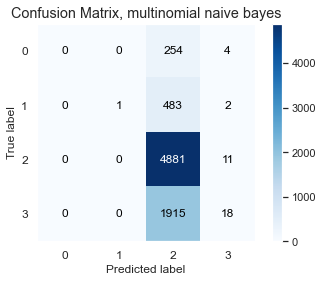

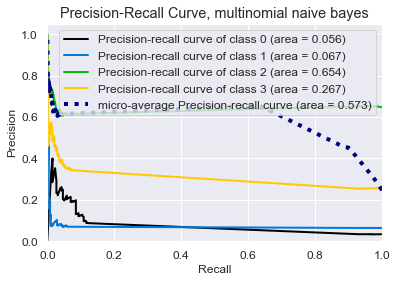

In [ ]:
# Confusion matrix and Precision Recall curve
skplt.metrics.plot_confusion_matrix(best_mnb['y_test'], best_mnb['best_model'].predict(best_mnb['X_test']), title="Confusion Matrix, multinomial naive bayes")
skplt.metrics.plot_precision_recall_curve(best_mnb['y_test'], best_mnb['best_model'].predict_proba(best_mnb['X_test']), title="Precision-Recall Curve, multinomial naive bayes")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# random forest with hyperparams
rf = RandomForestClassifier()
rf_parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,None]
}

# get outputs
best_rf = run_classification_model(rf,rf_parameters, entire_text_features, entire_text_labels)

Accuracy: 0.644867221561633
F1 Score: 0.7695565731982691
              precision    recall  f1-score   support

           0       0.01      0.50      0.02         6
           1       0.00      0.50      0.00         2
           2       0.99      0.65      0.78      7427
           3       0.03      0.39      0.05       134

    accuracy                           0.64      7569
   macro avg       0.26      0.51      0.22      7569
weighted avg       0.97      0.64      0.77      7569



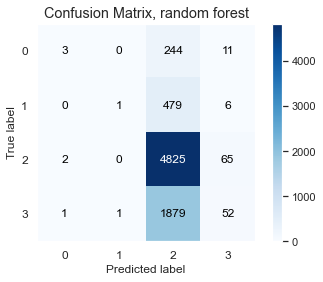

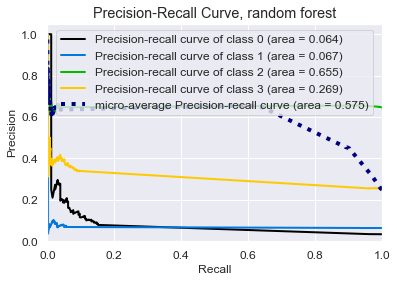

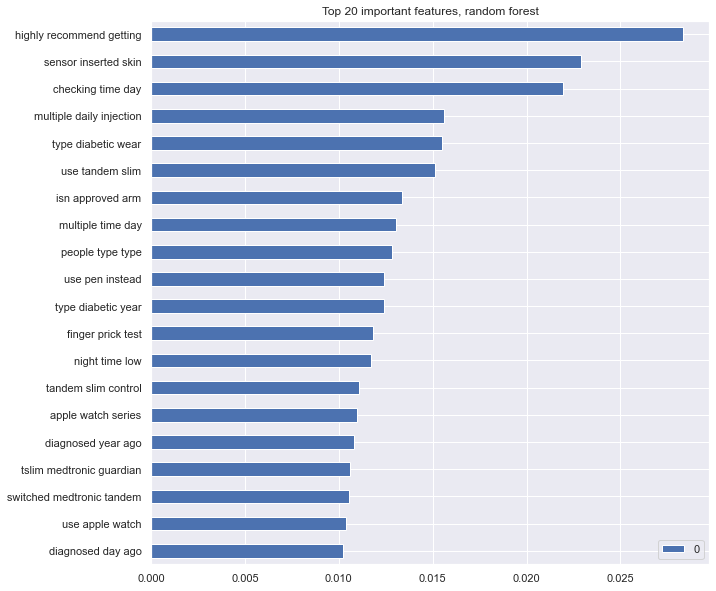

In [ ]:
skplt.metrics.plot_confusion_matrix(best_rf['y_test'], best_rf['best_model'].predict(best_rf['X_test']), title="Confusion Matrix, random forest")
skplt.metrics.plot_precision_recall_curve(best_rf['y_test'], best_rf['best_model'].predict_proba(best_rf['X_test']),title="Precision-Recall Curve, random forest")
# Shown below are the top 10 words found from the random forest algorithm
top20_features_rf = pd.DataFrame(best_rf['best_model'].feature_importances_, index = entire_text_set['feature_names'])
top20_features_rf.nlargest(20, 0).plot(kind='barh',figsize=(10,10)).invert_yaxis()
plt.title("Top 20 important features, random forest")
plt.show()

In [ ]:
xgb = xgb.XGBClassifier()
xgb_parameters = {
    # 'n_estimators': [5,50,100],
    # 'max_depth': [2,10,20,None]
}

best_xgb = run_classification_model(xgb,xgb_parameters, entire_text_features, entire_text_labels)

Accuracy: 0.6471132249966971
F1 Score: 0.7766002006998747
              precision    recall  f1-score   support

           0       0.01      0.60      0.02         5
           1       0.00      0.50      0.00         2
           2       0.99      0.65      0.79      7483
           3       0.02      0.46      0.04        79

    accuracy                           0.65      7569
   macro avg       0.26      0.55      0.21      7569
weighted avg       0.98      0.65      0.78      7569



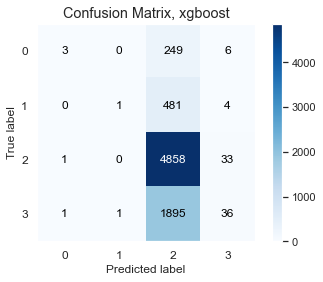

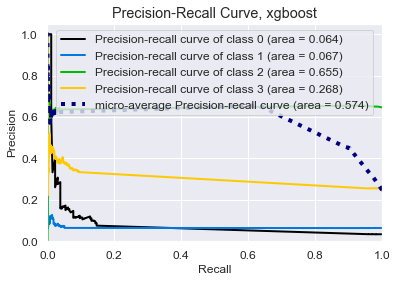

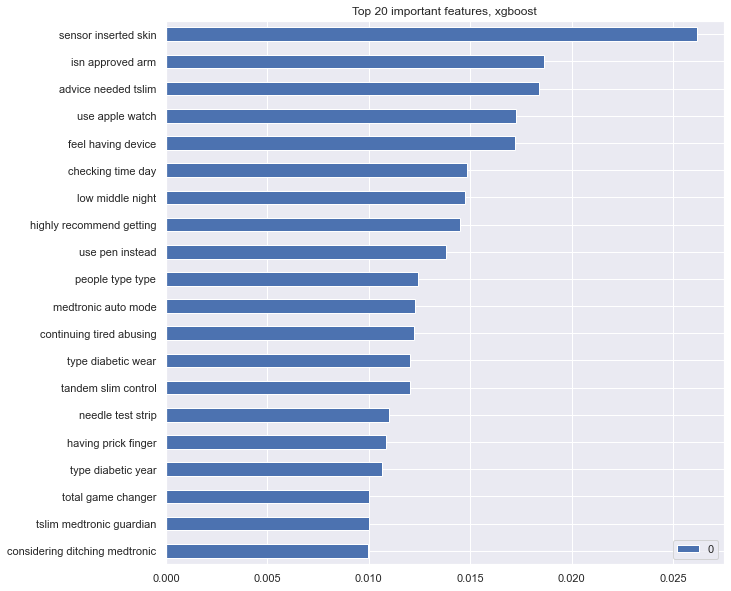

In [ ]:
# Plot outputs for xgboost
skplt.metrics.plot_confusion_matrix(best_xgb['y_test'], best_xgb['best_model'].predict(best_xgb['X_test']), title="Confusion Matrix, xgboost")
skplt.metrics.plot_precision_recall_curve(best_xgb['y_test'], best_xgb['best_model'].predict_proba(best_xgb['X_test']),title="Precision-Recall Curve, xgboost")
# Shown below are the top 10 words found from the xgboost algorithm
top20_features_rf = pd.DataFrame(best_xgb['best_model'].feature_importances_, index = entire_text_set['feature_names'])
top20_features_rf.nlargest(20, 0).plot(kind='barh',figsize=(10,10)).invert_yaxis()
plt.title("Top 20 important features, xgboost")
plt.show()

In [ ]:
contain_values = df_dexcom[df_dexcom['lemmatized_entire_text'].str.contains('sensor|insert|skin')]
print(contain_values[['Sound Bite Text']].sample(3).to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Sound Bite Text
23058  You can call Dexcom to fact check me. If the Dexcom reading is 100 mg/dl or less and there's a greater than 20 POINT difference, calibrate. Abov

### Run for the dexcom set

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb_parameters = {}

best_mnb = run_classification_model(mnb,mnb_parameters, dexcom_features, dexcom_labels)

mixed_class_prob_sorted = best_mnb['best_model'].feature_log_prob_[0, :].argsort()[::-1]
neg_class_prob_sorted =  best_mnb['best_model'].feature_log_prob_[1, :].argsort()[::-1]
neutral_class_prob_sort = best_mnb['best_model'].feature_log_prob_[2, :].argsort()[::-1]
pos_class_prob_sorted = best_mnb['best_model'].feature_log_prob_[3, :].argsort()[::-1]


print("top 10 negative words:\n" , np.take(dexcom_set['feature_names'], neg_class_prob_sorted[:10]))
print("\ntop 10 positive words:\n" ,np.take(dexcom_set['feature_names'], pos_class_prob_sorted[:10]))

Accuracy: 0.6152060359837492
F1 Score: 0.7502736507232448
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         3
           2       0.99      0.62      0.76      3396
           3       0.02      0.47      0.05        47

    accuracy                           0.62      3446
   macro avg       0.25      0.27      0.20      3446
weighted avg       0.98      0.62      0.75      3446

top 10 negative words:
 ['weekly vent thread' 'hybrid closed loop' 'daily meme day'
 'hour new sensor' 'build app update' 'base version update'
 'update base version' 'app update base' 'use closed loop'
 'day new sensor']

top 10 positive words:
 ['diagnosed year ago' 'medtronic guardian sensor' 'use tandem slim'
 'isn approved arm' 'highly recommend getting' 'iphone apple watch'
 'apple watch series' 'weekly vent thread' 'insurance won cover'
 'hybrid closed loop']


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,None]
}

best_rf = run_classification_model(rf,rf_parameters, dexcom_features, dexcom_labels)

Accuracy: 0.610272780034823
F1 Score: 0.7316582790444225
              precision    recall  f1-score   support

           0       0.01      0.50      0.02         2
           1       0.00      0.00      0.00         4
           2       0.97      0.62      0.76      3321
           3       0.05      0.38      0.09       119

    accuracy                           0.61      3446
   macro avg       0.26      0.37      0.21      3446
weighted avg       0.94      0.61      0.73      3446



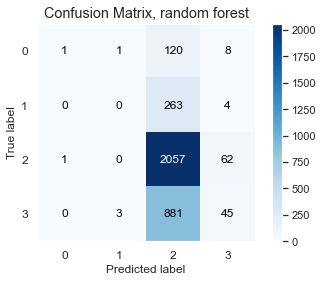

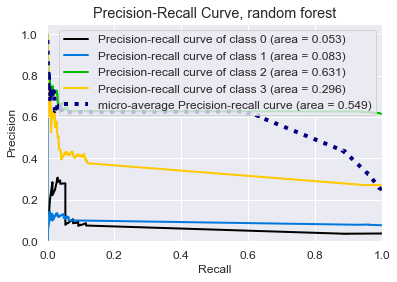

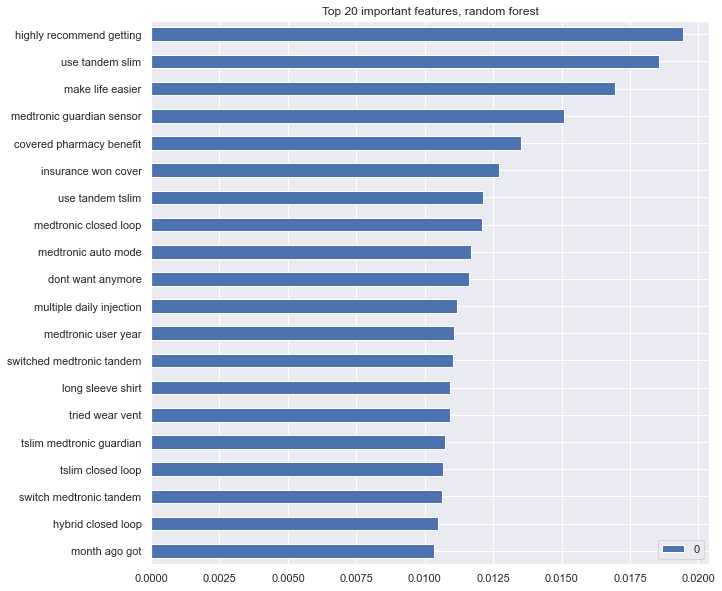

In [ ]:
skplt.metrics.plot_confusion_matrix(best_rf['y_test'], best_rf['best_model'].predict(best_rf['X_test']), title="Confusion Matrix, random forest")
skplt.metrics.plot_precision_recall_curve(best_rf['y_test'], best_rf['best_model'].predict_proba(best_rf['X_test']),title="Precision-Recall Curve, random forest")
# Shown below are the top 10 words found from the random forest algorithm
top20_features_rf = pd.DataFrame(best_rf['best_model'].feature_importances_, index = dexcom_set['feature_names'])
top20_features_rf.nlargest(20, 0).plot(kind='barh',figsize=(10,10)).invert_yaxis()
plt.title("Top 20 important features, random forest")
plt.show()

In [ ]:
xgb = xgb.XGBClassifier()
xgb_parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

best_xgb = run_classification_model(xgb,xgb_parameters, dexcom_features, dexcom_labels)

Accuracy: 0.6146256529309344
F1 Score: 0.7431466481568667
              precision    recall  f1-score   support

           0       0.02      0.40      0.03         5
           1       0.00      0.00      0.00         1
           2       0.98      0.62      0.76      3365
           3       0.04      0.44      0.07        75

    accuracy                           0.61      3446
   macro avg       0.26      0.36      0.21      3446
weighted avg       0.96      0.61      0.74      3446



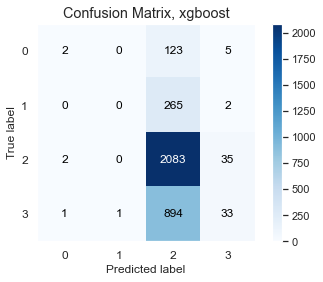

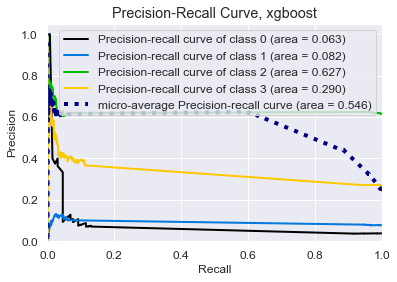

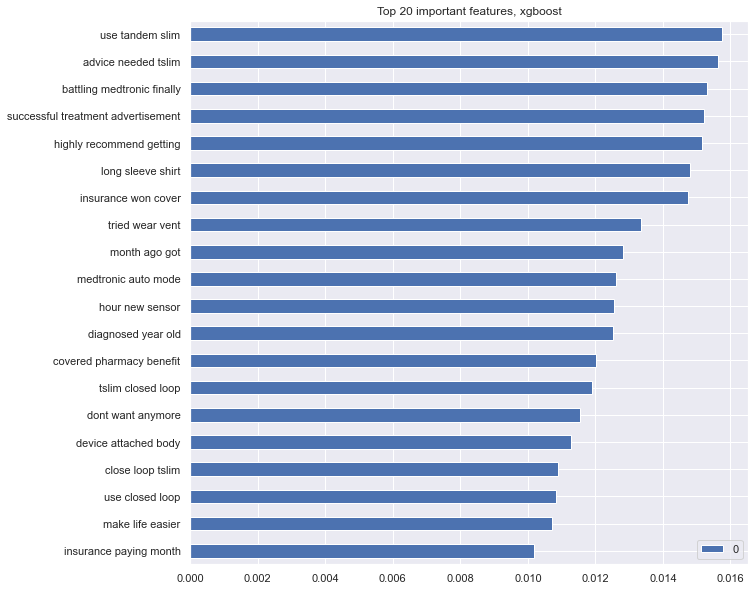

In [ ]:
skplt.metrics.plot_confusion_matrix(best_xgb['y_test'], best_xgb['best_model'].predict(best_xgb['X_test']), title="Confusion Matrix, xgboost")
skplt.metrics.plot_precision_recall_curve(best_xgb['y_test'], best_xgb['best_model'].predict_proba(best_xgb['X_test']),title="Precision-Recall Curve, xgboost")
# Shown below are the top 10 words found from the xgboost algorithm
top20_features_rf = pd.DataFrame(best_xgb['best_model'].feature_importances_, index = dexcom_set['feature_names'])
top20_features_rf.nlargest(20, 0).plot(kind='barh',figsize=(10,10)).invert_yaxis()
plt.title("Top 20 important features, xgboost")
plt.show()

In [ ]:
contain_values = df_dexcom[df_dexcom['lemmatized_entire_text'].str.contains('use|tandem|slim')]
print(contain_values[['Sound Bite Text']].sample(3).to_string())

### Run for the libre set

In [ ]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()
mnb_parameters = {}

best_mnb = run_classification_model(mnb,mnb_parameters, libre_features, libre_labels)

mixed_class_prob_sorted = best_mnb['best_model'].feature_log_prob_[0, :].argsort()[::-1]
neg_class_prob_sorted =  best_mnb['best_model'].feature_log_prob_[1, :].argsort()[::-1]
neutral_class_prob_sort = best_mnb['best_model'].feature_log_prob_[2, :].argsort()[::-1]
pos_class_prob_sorted = best_mnb['best_model'].feature_log_prob_[3, :].argsort()[::-1]


print("top 10 negative words:\n" , np.take(dexcom_set['feature_names'], neg_class_prob_sorted[:10]))
print("\ntop 10 positive words:\n" ,np.take(dexcom_set['feature_names'], pos_class_prob_sorted[:10]))

Accuracy: 0.6193771626297578
F1 Score: 0.7366690948825351
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.98      0.62      0.76       837
           3       0.07      0.60      0.12        30

    accuracy                           0.62       867
   macro avg       0.26      0.31      0.22       867
weighted avg       0.95      0.62      0.74       867

top 10 negative words:
 ['insurance wont cover' 'closest thing cure' 'diabetic year battling'
 'mark medtronic wondered' 'paying tslim supply' 'hit year mark'
 'pricking finger time' 'new sensor day' 'insurance paying month'
 'recently diagnosed type']

top 10 positive words:
 ['medical supply company' 'diagnosed year ago' 'device attached body'
 'noticing app having' 'month way high' 'insurance tried deny'
 'good job team' 'new insurance tried' 'europe better hear'
 'mark medtronic wondered']


In [ ]:
rf = RandomForestClassifier()
rf_parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,None]
}

best_rf = run_classification_model(rf,rf_parameters, libre_features, libre_labels)

Accuracy: 0.6147635524798154
F1 Score: 0.7312908700267429
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         4
           2       0.97      0.62      0.76       835
           3       0.06      0.61      0.11        28

    accuracy                           0.61       867
   macro avg       0.26      0.31      0.22       867
weighted avg       0.94      0.61      0.73       867



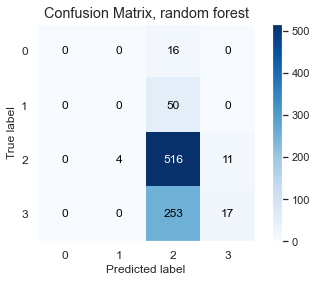

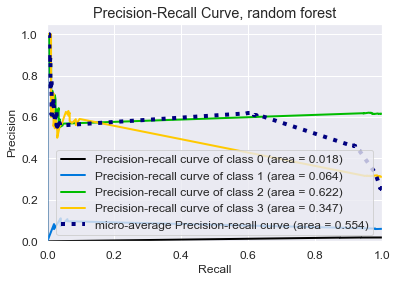

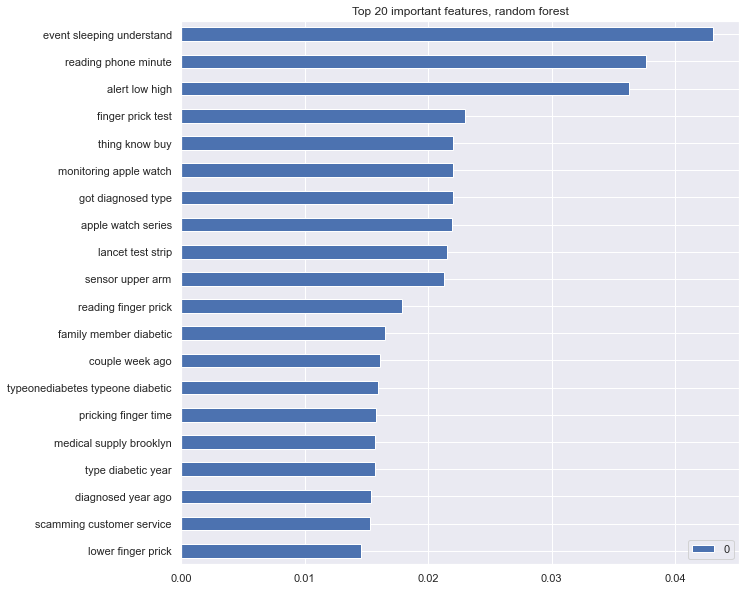

In [ ]:
skplt.metrics.plot_confusion_matrix(best_rf['y_test'], best_rf['best_model'].predict(best_rf['X_test']), title="Confusion Matrix, random forest")
skplt.metrics.plot_precision_recall_curve(best_rf['y_test'], best_rf['best_model'].predict_proba(best_rf['X_test']),title="Precision-Recall Curve, random forest")
# Shown below are the top 10 words found from the random forest algorithm
top20_features_rf = pd.DataFrame(best_rf['best_model'].feature_importances_, index = libre_set['feature_names'])
top20_features_rf.nlargest(20, 0).plot(kind='barh',figsize=(10,10)).invert_yaxis()
plt.title("Top 20 important features, random forest")
plt.show()

In [ ]:
xgb = xgb.XGBClassifier()
xgb_parameters = {
    'n_estimators': [5,50,100],
    'max_depth': [2,10,20,None]
}

best_xgb = run_classification_model(xgb,xgb_parameters, libre_features, libre_labels)

Accuracy: 0.6101499423298731
F1 Score: 0.7337886108929081
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         4
           2       0.98      0.62      0.76       840
           3       0.04      0.58      0.08        19

    accuracy                           0.61       867
   macro avg       0.25      0.30      0.21       867
weighted avg       0.95      0.61      0.73       867



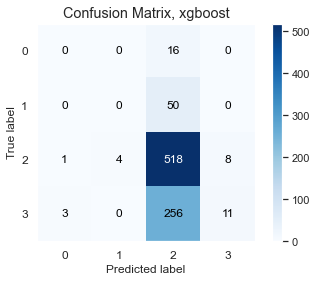

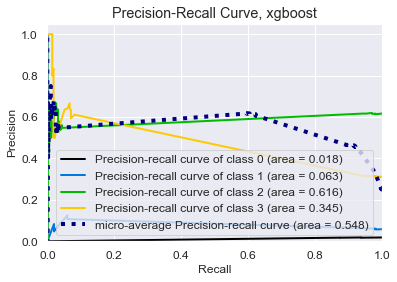

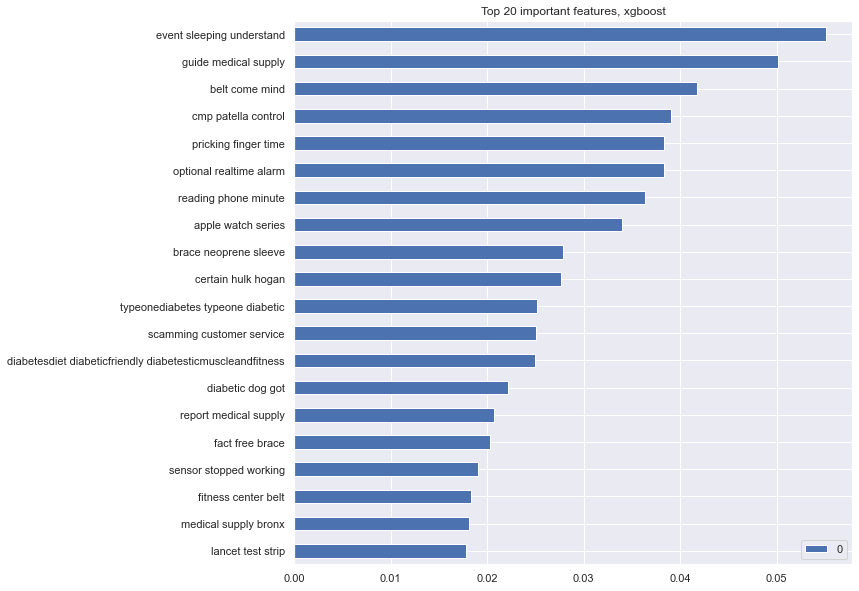

In [ ]:
skplt.metrics.plot_confusion_matrix(best_xgb['y_test'], best_xgb['best_model'].predict(best_xgb['X_test']), title="Confusion Matrix, xgboost")
skplt.metrics.plot_precision_recall_curve(best_xgb['y_test'], best_xgb['best_model'].predict_proba(best_xgb['X_test']),title="Precision-Recall Curve, xgboost")
# Shown below are the top 10 words found from the xgboost algorithm
top20_features_rf = pd.DataFrame(best_xgb['best_model'].feature_importances_, index = libre_set['feature_names'])
top20_features_rf.nlargest(20, 0).plot(kind='barh',figsize=(10,10)).invert_yaxis()
plt.title("Top 20 important features, xgboost")
plt.show()

In [ ]:
contain_values = df_libre[df_libre['lemmatized_entire_text'].str.contains('event|sleep|understand')]
print(contain_values[['Sound Bite Text']].sample(3).to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Sound Bite Text
1621                                                          Consider getting a continuous glucose monitor. You should be checking your bs, I don't know why your endo isn't having you do it. I was getting high morning readings & nothing I did helped, until I got the Freestyle Libre and realized I was getting hypos every morning around 3-4 AM, followed by a big spike. They didn't wake me up. I'm on an insulin pump so I adjusted my overnight basal and added a midnight snack.
12799                                     